Will the results of each training be different? Why?

The results may vary each time you train a deep learning model. Here are the main reasons for this:

1. **Random initialization**: The weights of deep learning models are usually randomly initialized at the beginning of training. Different initialization may cause the model to converge to different local optimal points, resulting in different training results.

2. **Random arrangement of training data**: If the training data is randomly shuffled during the training process, the order of each batch of training data will be different, which may also lead to different training results.

3. **Operations of randomness**: Some operations during the training process may involve randomness, such as dropout and certain data enhancement techniques. These elements of randomness can produce different effects each time you train.

4. **Optimization Algorithms**: Some optimization algorithms are stochastic, such as stochastic gradient descent (SGD). This randomness can also lead to different training trajectories and results.

5. **Small differences in hardware and software**: Different hardware or software implementations may cause small numerical differences that can accumulate to significant differences over many iterations.

6. **Parallel processing**: When training in a multi-GPU or multi-threaded environment, different results may occur because the order of execution of operations may be slightly different.

7. **Hyperparameter Selection**: If hyperparameters (such as learning rate, batch size, etc.) are changed between different training runs, then the results will also vary.

Due to the existence of these factors, the training of deep learning models usually has a certain degree of uncertainty. If you want to ensure the same results between different runs, you can try setting a random seed to fix the behavior of the random operation, but even then, there may still be some non-repeatable parts due to factors such as hardware and software differences.

In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import numpy as np  # Linear algebra library
import pandas as pd  # Data processing library, used for reading and writing CSV files
import matplotlib.pyplot as plt  # Drawing library
import matplotlib.dates as mdates  # Date handling library
import matplotlib.ticker as tkr  # Tick handling library
import seaborn as sns  # Statistical data visualization library
import nltk  # Natural language processing library
nltk.download('vader_lexicon')  # Download the VADER sentiment analysis tool
from nltk.sentiment import SentimentIntensityAnalyzer  # Import sentiment analysis tool

# Input data files are located in the read-only directory "/kaggle/input/"
# For example, running the following code will list all files in the input directory
# Import the os module
import os

# Use the os.walk() method to traverse all files and subdirectories in the specified directory
# '/kaggle/input' is the specified directory path, which you can replace with the directory you want to traverse
# The os.walk() method returns a generator that produces a 3-tuple (current directory path, list of subdirectories in the current directory, list of files in the current directory)
for dirname, _, filenames in os.walk('/kaggle/input'):
    # Traverse the file list filenames of the current directory
    for filename in filenames:
        # Use the os.path.join() method to concatenate the directory path and filename to get the full path of the file
        file_path = os.path.join(dirname, filename)
        # Print the full path of the file
        print(file_path)


2023-08-05 20:33:30.359903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lixiaofei/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Stock information: stock code, date (the format may be incorrect), opening, high and low prices

In [2]:
# Importing the detailed content of tweets
tweets = pd.read_csv('./2015_to_2020/Tweet.csv')
# Importing the association between stock ticker and tweeter ID from Company_Tweet.csv
company_tweet = pd.read_csv('./2015_to_2020/Company_Tweet.csv')

# Merging the two files
tweets = tweets.merge(company_tweet, how='left', on='tweet_id')
# Formatting dates
tweets['date'] = pd.to_datetime(tweets['post_date'], unit='s').dt.date
tweets.date = pd.to_datetime(tweets.date, errors='coerce')
tweets['time'] = pd.to_datetime(tweets['post_date'], unit='s').dt.time
# Renaming the 'date' column to 'Date'
tweets.rename(columns={'date': 'Date'}, inplace=True)
tweets.rename(columns={'body': 'Tweet'}, inplace=True)
tweets.rename(columns={'ticker_symbol': 'Stock Name'}, inplace=True)
# Dropping columns
tweets.drop(columns=['comment_num', 'retweet_num', 'tweet_id', 'writer', 'like_num', 'post_date', 'time'], inplace=True)
print(tweets.shape)
tweets.head()


(4336445, 3)


,Tweet,Stock Name,Date
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01
1,Insanity of today weirdo massive selling. $aap...,AAPL,2015-01-01
2,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN,2015-01-01
3,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,TSLA,2015-01-01
4,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01


In [3]:
stock_name = 'AAPL'


df = tweets[tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(1425013, 3)


,Tweet,Stock Name,Date
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01
1,Insanity of today weirdo massive selling. $aap...,AAPL,2015-01-01
4,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01
6,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01
8,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01


In [4]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
# sent_df = sent_df.head(1000)
sent_df.head()

,Tweet,Stock Name,Date,sentiment_score,Negative,Neutral,Positive
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01,,,,
1,Insanity of today weirdo massive selling. $aap...,AAPL,2015-01-01,,,,
4,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,,,,
6,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,,,,
8,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,,,,


To obtain sentiment (polarity) scores, we used the VADER (Valence Aware Dictionary for Affective Reasoning) model. VADER is a model for text sentiment analysis that is sensitive to both the polarity (positive/negative) and intensity (intensity) of sentiment. It is available in the NLTK package and can be applied directly to unlabeled text data.

VADER sentiment analysis relies on a lexicon that maps lexical features to sentiment intensities (i.e., sentiment scores). The sentiment score of a text can be obtained by summing the intensity of each word in the text.

In [5]:
# Import the sentiment analyzer
sentiment_analyzer = SentimentIntensityAnalyzer()

# Iterate over each row of data
for indx, row in sent_df.T.iteritems():
    try:
        # Extract the tweet content of the current row
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])

        # Perform sentiment analysis and obtain sentiment score
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)

        # Add the sentiment score to the DataFrame
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']

    # If a TypeError exception occurs, print the exception message and break the loop
    except TypeError:
        print("TypeError occurred:")
        print(sent_df.loc[indexx, 'Tweet'])  # Print the tweet content where the exception occurred
        print(indx)  # Print the index where the exception occurred
        break


In [6]:
sent_df.head()

,Tweet,Stock Name,Date,sentiment_score,Negative,Neutral,Positive
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01,0.0,0.0,1.0,0.0
1,Insanity of today weirdo massive selling. $aap...,AAPL,2015-01-01,-0.8271,0.339,0.661,0.0
4,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,0.0,0.0,1.0,0.0
6,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,0.0,0.0,1.0,0.0
8,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,0.0,0.0,1.0,0.0


In [7]:
# from DataFrame remove 'Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name' 列
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral'])

In [8]:
sent_df.head()

,Tweet,Stock Name,Date,sentiment_score
0,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL,2015-01-01,0.0
1,Insanity of today weirdo massive selling. $aap...,AAPL,2015-01-01,-0.8271
4,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,0.0
6,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,0.0
8,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL,2015-01-01,0.0


In [9]:
twitter_df = sent_df.groupby([sent_df['Date']]).mean()
# Convert the "Date" column to datetime type
twitter_df.index = pd.to_datetime(twitter_df.index)
print(twitter_df.shape)

(1819, 1)


In [10]:
twitter_df.head()

,sentiment_score
Date,
2015-01-01,0.145556
2015-01-02,0.088663
2015-01-03,0.237232
2015-01-04,0.221782
2015-01-05,0.143573


In [11]:
print(twitter_df.index.dtype)


datetime64[ns]


In [12]:
# import prices

sent_df=pd.read_csv('./2010_to_2020/CompanyValues.csv')
# format date
# Convert the 'day_date' column in the prices DataFrame to a date format and use the specified date format for conversion.
# Then convert it to a datetime type of datetime64[ns].
# And store the result back to the 'day_date' column in the prices DataFrame.
sent_df['day_date'] = pd.to_datetime(sent_df['day_date'], format="%Y-%m-%d").dt.date.astype('datetime64[ns]')
# Sort the prices DataFrame by the values in the 'day_date' column and reset the index.
sent_df=sent_df.sort_values(by=['day_date']).reset_index()
# Rename the 'day_date' column to 'date' for consistency.
sent_df=sent_df.rename(columns={"day_date": "date"})
# Change the column name 'date' to 'Date'
sent_df.rename(columns={'date': 'Date'}, inplace=True)
# Change the column name 'ticker_symbol' to 'Stock Name'
sent_df.rename(columns={'ticker_symbol': 'Stock Name'}, inplace=True)
sent_df.rename(columns={'close_value': 'Close'}, inplace=True)
sent_df.rename(columns={'open_value': 'Open'}, inplace=True)
sent_df.rename(columns={'high_value': 'High'}, inplace=True)
sent_df.rename(columns={'low_value': 'Low'}, inplace=True)
sent_df.rename(columns={'volume': 'Volume'}, inplace=True)
# Drop the 'index' column
sent_df.drop(columns=['index'], inplace=True)
sent_df.head()
print(sent_df.shape)


(17528, 7)


In [13]:
stock_df = sent_df[sent_df['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date
#Object to datetime64[ns]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

In [14]:
print(stock_df['Date'].dtypes)
stock_df.head()


datetime64[ns]


,Stock Name,Date,Close,Volume,Open,High,Low
1,AAPL,2010-06-01,37.2614,218455576,37.0986,37.9914,36.9943
6,AAPL,2010-06-02,37.7071,171594061,37.7914,37.8286,37.1907
10,AAPL,2010-06-03,37.5886,162341809,37.8828,37.9357,37.2014
13,AAPL,2010-06-04,36.5664,189045767,36.8871,37.4143,36.3757
17,AAPL,2010-06-07,35.8486,221253336,36.8986,37.0214,35.7928


In [15]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(3085, 7)


Let's plot the historical price data for the stock symbol analyzed:

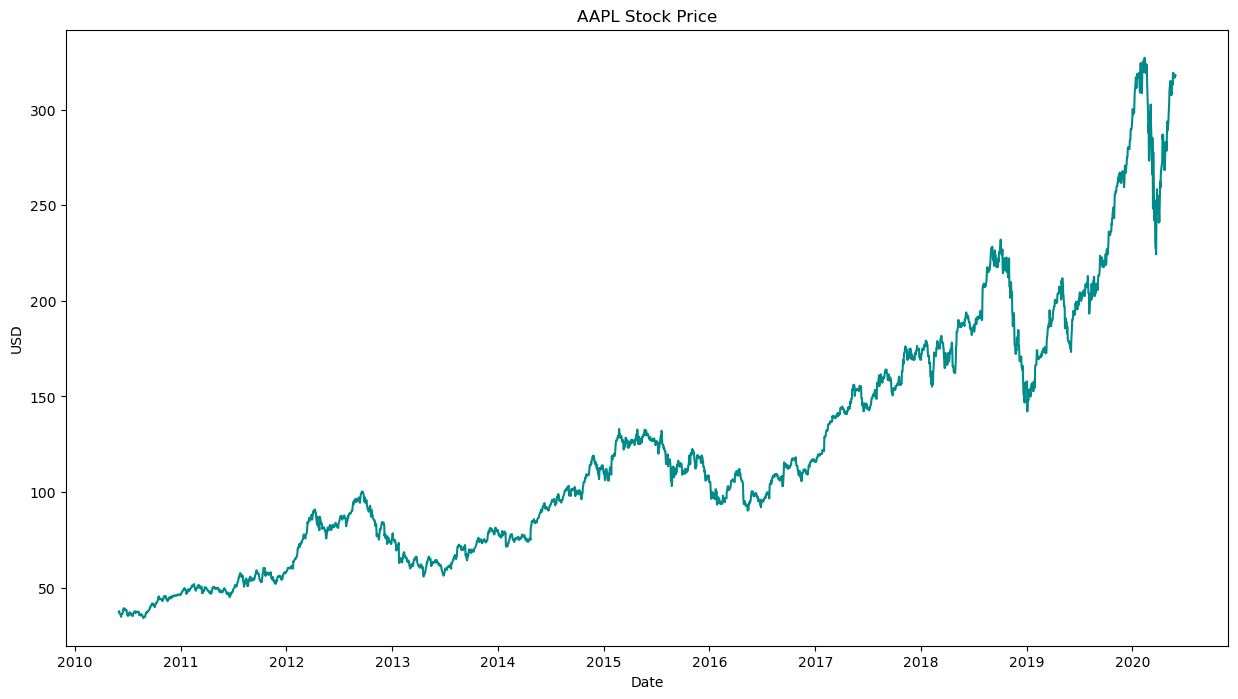

In [16]:
# Create a new figure and subplot object, setting the figure size to (15, 8)
fig, ax = plt.subplots(figsize=(15, 8))

# Plot a line chart on the subplot with the x-axis data from the 'Date' column and the y-axis data from the 'Close' column. Set the line color to '#008B8B' (dark cyan)
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')

# Set the subplot's x-axis label to "Date", y-axis label to "USD", and the title to "{stock_name} Stock Price", where {stock_name} is a variable representing the stock name
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")

# Set the x-axis date format to "%Y", displaying only the year
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# Display the plotted figure
plt.show()


Adding technical indicators To help the network understand the big picture of the market, we added different technical indicators to the training data, such as moving averages, Bollinger Bands, etc. These indicators not only describe the stock price trend of the day, but also describe the past week or longer stock price trends over time.

MA(7) represents the moving average of the past 7 days, while MA(20) represents the moving average of the past 20 days.

EMA is an exponential moving average and is calculated as

EMA_t = Pclose + (EMA_t-1 (100 - P))*. The calculation formula of Bollinger Bands is

Center line: stdev(MA(20)) Upper limit: MA(20) + 2stdev(MA(20)) Lower limit: MA(20) - 2stdev(MA(20)) MA(20) - 2stdev(MA(20))

In [17]:
# Define the function get_tech_ind(data) to calculate technical indicators
def get_tech_ind(data):
    # Calculate 7-day and 20-day moving averages (MA7 and MA20)
    data['MA7'] = data.iloc[:, 4].rolling(window=7).mean()  # Calculated using the Close column
    data['MA20'] = data.iloc[:, 4].rolling(window=20).mean()  # Calculated using the Close column

    # Calculate Moving Average Convergence Divergence (MACD)
    data['MACD'] = data.iloc[:, 4].ewm(span=26).mean() - data.iloc[:, 1].ewm(span=12, adjust=False).mean()
    # Calculated using the Close and Open columns, representing the difference between closing and opening prices

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()  # Calculate the standard deviation using the Close column
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)  # Upper band is MA20 plus twice the 20SD
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)  # Lower band is MA20 minus twice the 20SD

    # Create Exponential Moving Average (EMA)
    data['EMA'] = data.iloc[:, 4].ewm(com=0.5).mean()  # Calculate EMA using the Close column with a smoothing factor of com

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:, 4] - 1)  # Calculate LogMomentum using the Close column, subtract 1 to avoid negative numbers

    return data


In [18]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Close,Volume,Open,High,Low,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2010-06-29,36.5957,282782865,37.7316,37.7700,36.3286,NaN,38.923357,37.884525,0.337593,1.234866,40.354256,35.414794,38.052547,3.604682
1,2010-06-30,35.9328,184538045,36.6728,36.8528,35.7157,NaN,38.493957,37.835735,0.511341,1.256283,40.348301,35.323169,37.252716,3.579422
2,2010-07-01,35.4971,255527517,36.3286,36.4000,34.7457,NaN,38.061914,37.758950,0.679133,1.296150,40.351251,35.166649,36.684239,3.566712
3,2010-07-02,35.2771,173446612,35.7843,35.8471,34.7428,NaN,37.577629,37.680590,0.798760,1.363696,40.407983,34.953197,36.126146,3.550970
4,2010-07-06,35.5186,153559326,35.8571,36.1143,35.1657,NaN,37.161414,37.635235,0.876280,1.401339,40.437914,34.832556,36.118249,3.558608


In [20]:
sentiment_series = pd.Series(dataset['sentiment_score'])
sentiment_series = sentiment_series.interpolate(method='linear')
# Use mean or median to fill remaining missing values
sentiment_series.fillna(sentiment_series.mean(), inplace=True)
# or
# sentiment_series.fillna(sentiment_series.median(), inplace=True)
dataset['sentiment_score'] = sentiment_series
num_missing = dataset['sentiment_score'].isnull().sum() 


In [23]:
# Define function tech_ind(dataset) to plot technical indicators
def tech_ind(dataset):
    # Create a plotting area
    fig, ax = plt.subplots(figsize=(15, 8), dpi=200)

    # Get x-axis data (dates)
    x_ = list(dataset.index)

    # Plot 7-day moving average
    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    
    # Plot closing price curve
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    
    # Plot 20-day moving average
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    
    # Set x-axis date format to year
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    
    # Set graph title, y-axis label, and x-axis label
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    
    # Display legend
    plt.legend()

    # Display graph
    plt.show()


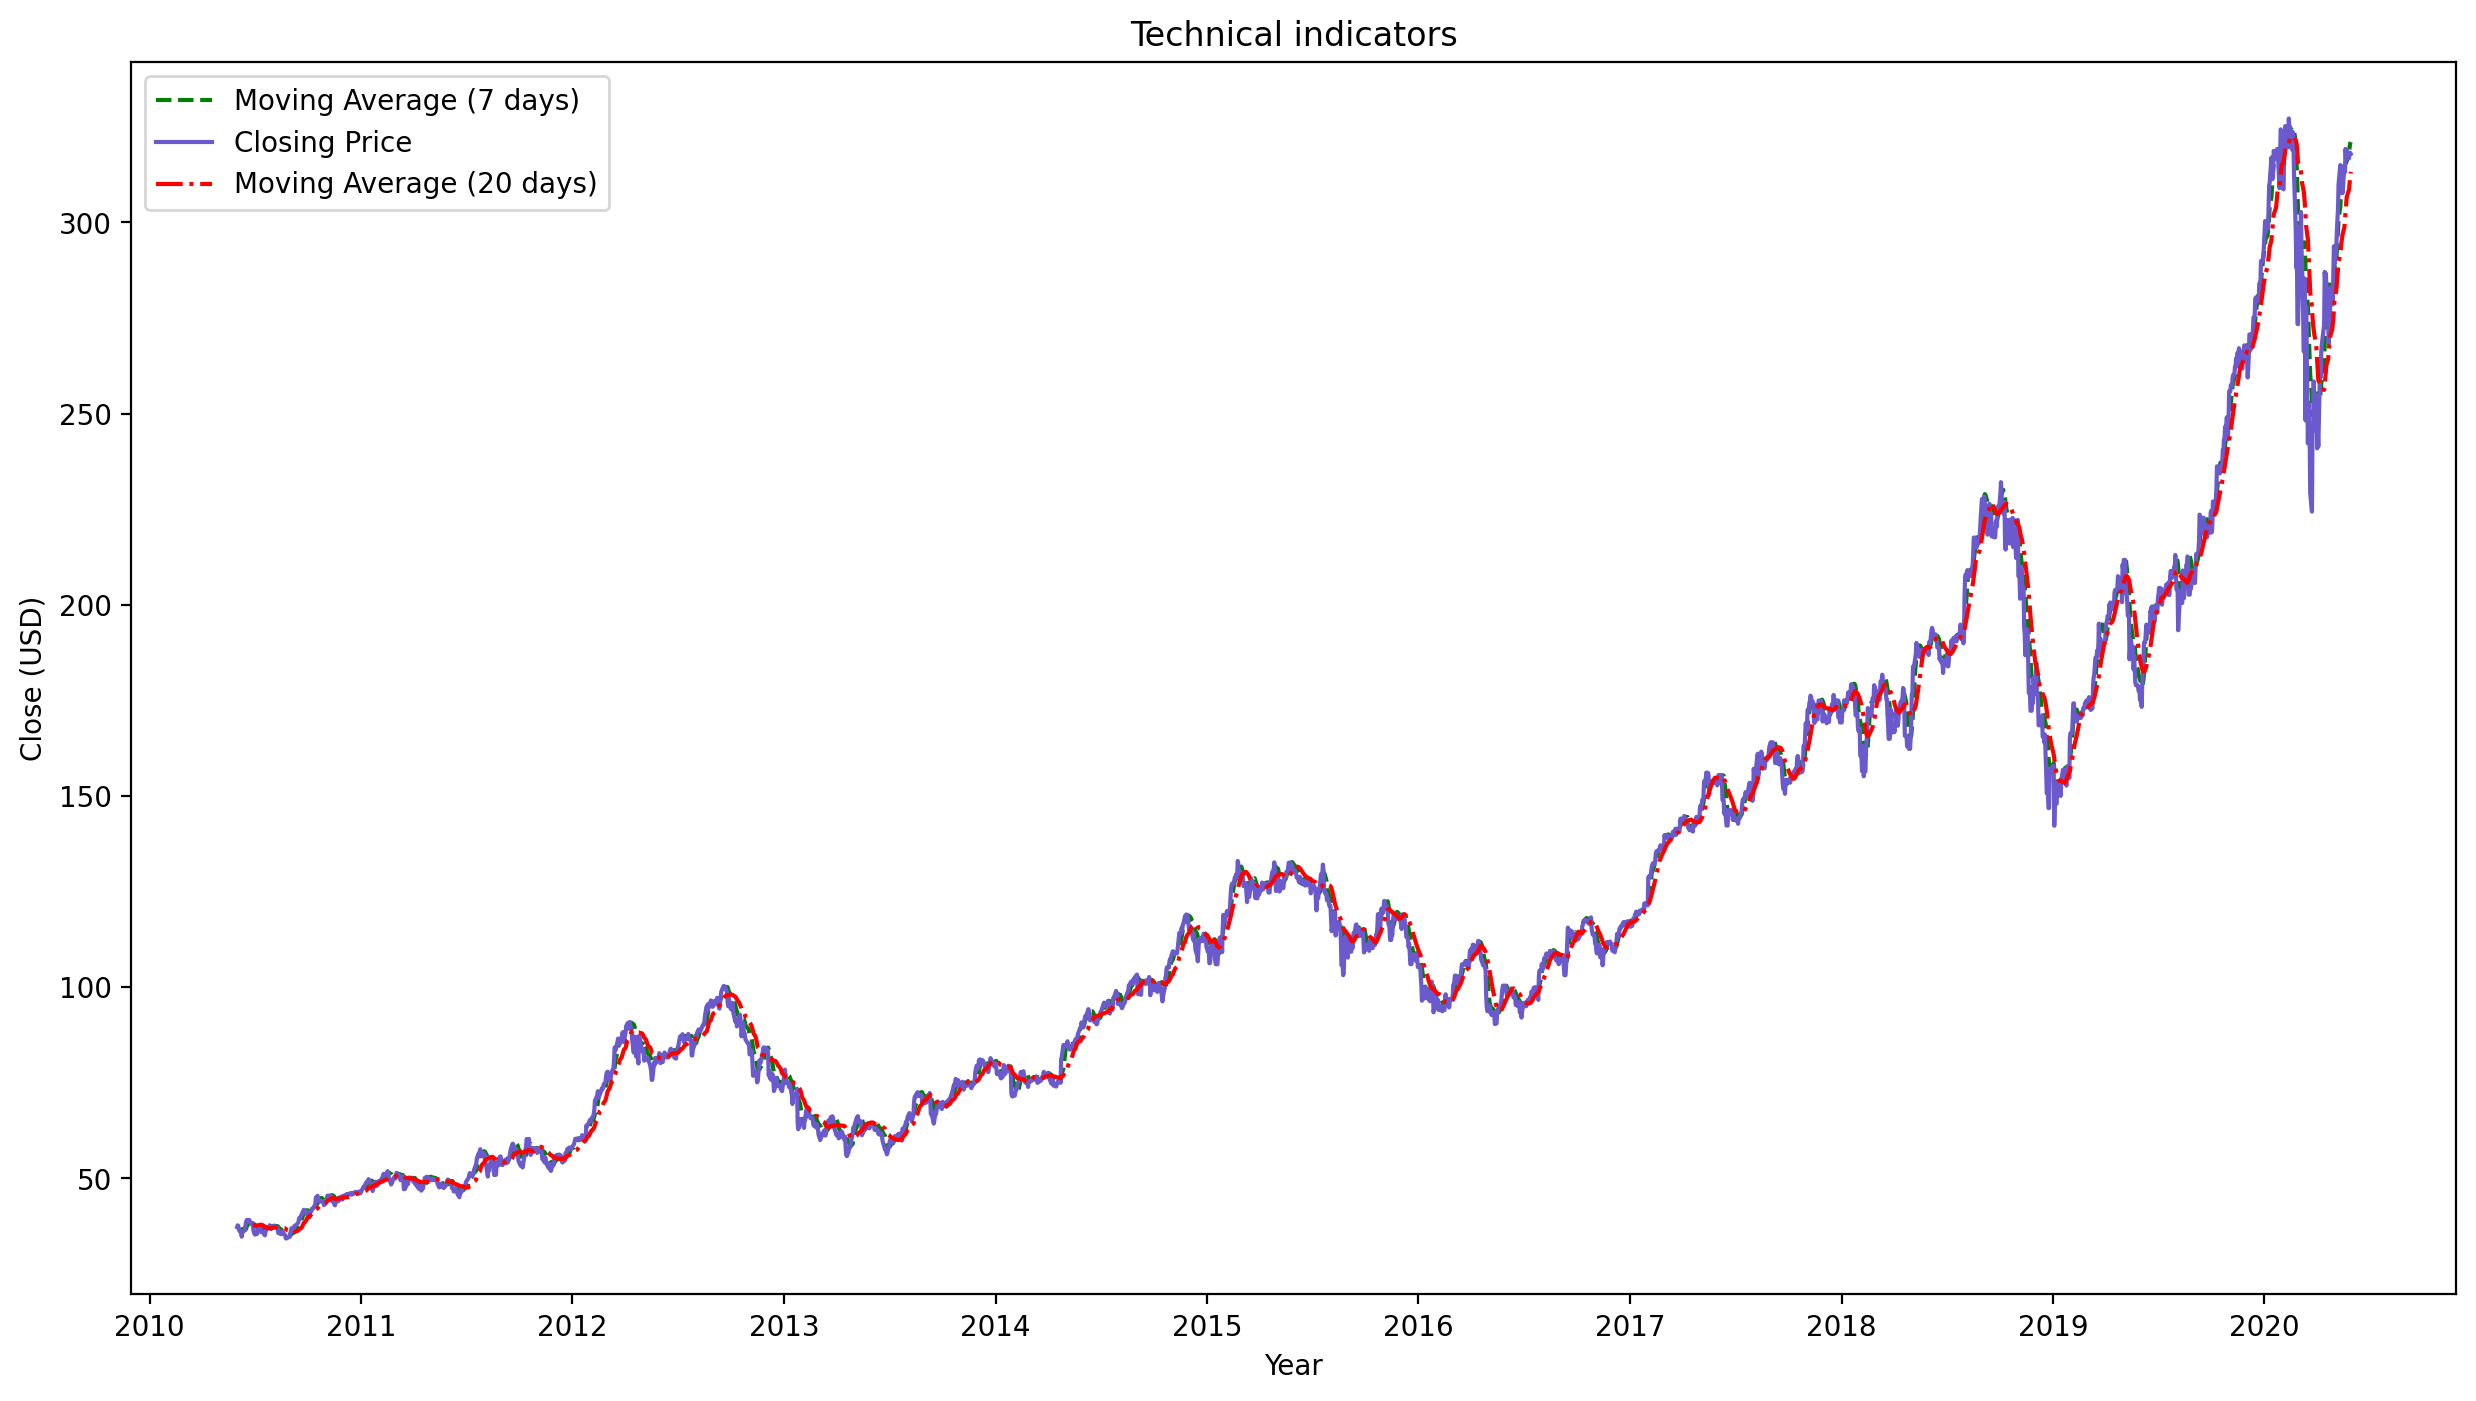

In [24]:
tech_ind(tech_df)

In [25]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [26]:
# Convert the 'Date' column string dates into pandas datetime type

datetime_series = pd.to_datetime(dataset['Date'])

# Create a DatetimeIndex object, using dates from 'datetime_series' as the index
datetime_index = pd.DatetimeIndex(datetime_series.values)

# Set the dataset 'dataset' index to 'datetime_index' for time series indexing by date
dataset = dataset.set_index(datetime_index)

# Sort the dataset 'dataset' in ascending order by date to ensure data is arranged from earliest to latest
dataset = dataset.sort_values(by='Date')

# Drop the 'Date' column from the dataset since the date already exists as an index
dataset = dataset.drop(columns='Date')


The main purpose of this code is to normalize (aka scale) the input and target features in the dataset.

Normalization is one of the preprocessing steps of machine learning, which can help the training algorithm to converge faster and more accurately

In [27]:
# Import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
import pandas as pd

def normalize_data(df, range, target_column):
    '''
    df: Dataframe, i.e., the data to be processed.
    range: A tuple indicating the normalization range, e.g., (0,1), signifying that normalized data will be between 0 and 1.
    target_column: Specifies the column name to be processed, of type string, typically representing stock closing price.
    '''

    # Get the target column data and form a new dataframe
    target_df_series = pd.DataFrame(df[target_column])
    # Make a copy of the entire dataframe
    data = pd.DataFrame(df.iloc[:, :])

    # Create a data scaler for input feature X
    X_scaler = MinMaxScaler(feature_range=range)
    # Create a data scaler for target feature y
    y_scaler = MinMaxScaler(feature_range=range)
    # Train the scaler on the input feature data
    X_scaler.fit(data)
    # Train the scaler on the target feature data
    y_scaler.fit(target_df_series)

    # Normalize the input feature data
    X_scale_dataset = X_scaler.transform(data)
    # Normalize the target feature data
    y_scale_dataset = y_scaler.transform(target_df_series)
    
    # Save the trained input feature scaler for future data processing
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    # Save the trained target feature scaler for future data processing
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    # Return the normalized input feature and target feature
    return (X_scale_dataset, y_scale_dataset)


This code implements the function of batching the input data x_data and y_data.

The main steps are:

Create three empty lists X_batched, y_batched, yc to store the batched data.

Traverse the input data x_data, and each time take out data of batch_size size as a batch of x_value.

Correspondingly, data of predict_period size is taken out from y_data as a batch of y_value. Here y_value is the data after x_value.

At the same time, the data in the same batch as x_value is taken from y_data as yc_value.

Check whether the lengths of x_value and y_value meet the requirements.

If satisfied, append this batch of data to the corresponding list.

Finally, the list storing the batch data is converted into a numpy array and returned.

In this way, by controlling the sizes of batch_size and predict_period, the input data can be divided into different small batches and the correspondence between x and y can be guaranteed.
This is a common means of data preprocessing in many machine learning tasks.

In [28]:
import numpy as np

def batch_data(x_data, y_data, batch_size, predict_period):
    # Create three empty lists to store the batched data
    X_batched, y_batched, yc = list(), list(), list()

    # Iterate over the input data
    for i in range(0, len(x_data), 1):
        # Extract a batch of data from x_data with size batch_size
        x_value = x_data[i: i + batch_size][:, :]
        # Extract a batch of data from y_data with size predict_period
        # This batch of data follows the batch taken from x_data
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        # Extract data from y_data that is in the same batch as x_data
        yc_value = y_data[i: i + batch_size][:, :]
        
        # If the lengths of extracted x_value and y_value meet the criteria
        # then add this batch to the corresponding list
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    # Convert the batched data lists to numpy arrays and return
    return np.array(X_batched), np.array(y_batched), np.array(yc)


In [29]:
def split_train_test(data):

    # Test set length is 1500 days
    test_size = 3000
    
    # Training set is total data minus the test set
    train_size = len(data) - test_size 

    # Training data includes all data except the last test_size days
    data_train = data[:-test_size]  

    # Test data consists of the last test_size days
    data_test = data[-test_size:]

    return data_train, data_test


In [30]:
def predict_index(dataset, X_train, batch_size, prediction_period):
    # Get the date index corresponding to the training set prediction data. 
    # To avoid having no predicted value for the first batch_size days, 
    # start from batch_size days later and take the index of 
    # X_train.shape[0] (size of the training set) + batch_size + prediction_period data.
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    
    # Get the date index corresponding to the test set prediction data. 
    # Start from the date after the end of the training set until the end of the dataset.
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    # Return the date index corresponding to the prediction results of the training and test sets.
    return train_predict_index, test_predict_index


In [31]:
# Using the normalize_data function to normalize the data, this function scales the data range to between -1 and 1, targeting the "Close" column (i.e., the stock's closing price). The returned X_scale_dataset and y_scale_dataset are the normalized feature data and target data, respectively.
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")

# Using the batch_data function to batch the normalized data, with a batch size set to 5 and prediction period set to 1. The returned X_batched, y_batched, and yc are the batched feature data, target data, and yc data respectively (here, the yc data refers to the original target data corresponding to the feature data).
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)

# Printing the shapes of the batched feature data, target data, and yc data.
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

# Using the split_train_test function to split the batched feature data, target data, and yc data into training and testing sets.
X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)

# Using the predict_index function to obtain the date indices corresponding to the prediction results of the training and testing sets.
index_train, index_test, = predict_index(dataset, X_train, 5, 1)


X shape: (3060, 5, 14)
y shape: (3060, 1)
yc shape: (3060, 5, 1)


In [32]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

In [33]:
def make_generator_model(input_dim, output_dim, feature_size):
    # Define a generator model using LSTM architecture
    model = tf.keras.Sequential([
        # First layer: LSTM with 1024 output units, input shape (input_dim, feature_size),
        # uses sequence return mode meaning each time step will produce an output, recurrent dropout rate is 0.3
        LSTM(units=1024, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.3),

        # Second layer: LSTM with 512 output units, also uses sequence return mode, recurrent dropout rate is 0.3
        LSTM(units=512, return_sequences=True, recurrent_dropout=0.3),

        # Third layer: LSTM with 256 output units, also uses sequence return mode, recurrent dropout rate is 0.3
        LSTM(units=256, return_sequences=True, recurrent_dropout=0.3),

        # Fourth layer: LSTM with 128 output units, also uses sequence return mode, recurrent dropout rate is 0.3
        LSTM(units=128, return_sequences=True, recurrent_dropout=0.3),

        # Fifth layer: LSTM with 64 output units, this layer doesn't use sequence return mode, 
        # so only the output from the last time step is returned, recurrent dropout rate is 0.3
        LSTM(units=64, recurrent_dropout=0.3),

        # Sixth layer: Dense layer with 32 output units
        Dense(32),

        # Seventh layer: Dense layer with 16 output units
        Dense(16),

        # Eighth layer: Dense layer with 8 output units
        Dense(8),

        # Last layer: Dense layer with output_dim as the number of output units, this serves as the final output
        Dense(units=output_dim)
    ])
    return model  # Return the model


In [34]:
def make_discriminator_model(input_dim):
    # Create a Sequential model object to stack various neural network layers
    cnn_net = tf.keras.Sequential()
    
    # Add the first 1D convolutional layer with 8 output channels and input shape of (input_dim+1, 1)
    # Kernel size is 3, stride is 2, padding is 'same', and activation function is LeakyReLU(alpha=0.01)
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    
    # Add the second 1D convolutional layer with 16 output channels
    # Kernel size is 3, stride is 2, padding is 'same', and activation function is LeakyReLU(alpha=0.01)
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    
    # Add the third 1D convolutional layer with 32 output channels
    # Kernel size is 3, stride is 2, padding is 'same', and activation function is LeakyReLU(alpha=0.01)
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    
    # Add the fourth 1D convolutional layer with 64 output channels
    # Kernel size is 3, stride is 2, padding is 'same', and activation function is LeakyReLU(alpha=0.01)
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    
    # Add the fifth 1D convolutional layer with 128 output channels
    # Kernel size is 1, stride is 2, padding is 'same', and activation function is LeakyReLU(alpha=0.01)
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    
    # Add LeakyReLU activation layer
    cnn_net.add(LeakyReLU())
    
    # Add a fully connected layer with 220 neurons without bias
    cnn_net.add(Dense(220, use_bias=False))
    
    # Add LeakyReLU activation layer
    cnn_net.add(LeakyReLU())
    
    # Add a fully connected layer with 220 neurons without bias and 'relu' activation function
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    
    # Add output layer with 1 neuron and 'sigmoid' activation function
    cnn_net.add(Dense(1, activation='sigmoid'))
    
    return cnn_net


In [35]:
def discriminator_loss(real_output, fake_output):
    # Create a binary cross-entropy loss function object, from_logits=True indicates that the predictions are not processed through the sigmoid function.
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Calculate the discriminator loss for real samples.
    # Use a vector of all ones as labels for real samples and compute the cross-entropy loss between real samples and discriminator outputs.
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    
    # Calculate the discriminator loss for generated samples.
    # Use a vector of all zeros as labels for generated samples and compute the cross-entropy loss between generated samples and discriminator outputs.
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    
    # The total discriminator loss is the sum of the real sample loss and the generated sample loss.
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # Create a binary cross-entropy loss function object, from_logits=True indicates that the predictions are not processed through the sigmoid function.
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    # Calculate the generator loss for generated samples.
    # Use a vector of all ones as labels for generated samples and compute the cross-entropy loss between generated samples and discriminator outputs.
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss


In [36]:
@tf.function
def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    """
    GAN training step function.

    Parameters:
        real_x: Real input data, a tensor of shape [batch_size, sequence_length].
        real_y: Real output data, a tensor of shape [batch_size, sequence_length].
        yc: Additional conditional information, a tensor of shape [batch_size, condition_length].
        generator: Generator model.
        discriminator: Discriminator model.
        g_optimizer: Generator optimizer.
        d_optimizer: Discriminator optimizer.

    Returns:
        real_y: Real output data.
        generated_data: Data generated by the generator.
        losses: A dictionary containing discriminator loss and generator loss.

    """
    # Use tf.GradientTape to monitor gradients of the generator and discriminator
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate data using the generator
        generated_data = generator(real_x, training=True)
        # Reshape the generated data for concatenation with conditional information
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        # Concatenate the generated data with conditional information
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        # Reshape the real output data for concatenation with conditional information
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        # Concatenate the real output data with conditional information
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        # Discriminator evaluates real and fake samples
        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        # Calculate generator loss and discriminator loss
        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients of generator and discriminator separately
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients to update parameters using optimizers
    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return the results
    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}


In [37]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint=50):
    """
    GAN training function.

    Args:
        real_x: Real input data, tensor of shape [batch_size, sequence_length].
        real_y: Real output data, tensor of shape [batch_size, sequence_length].
        yc: Additional conditional information, tensor of shape [batch_size, condition_length].
        Epochs: Number of training epochs.
        generator: Generator model.
        discriminator: Discriminator model.
        g_optimizer: Generator optimizer.
        d_optimizer: Discriminator optimizer.
        checkpoint: Save the model every 'checkpoint' epochs, default is 50.

    Returns:
        Predicted_price: Predicted price array.
        Real_price: Real price array.
        rmse: Root Mean Square Error (RMSE) normalized by the mean of real prices.
    """
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        # Save the model every 'checkpoint' epochs
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    # Convert to NumPy arrays and reshape
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    # Plot loss curves
    plt.subplot(2, 1, 1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    # Calculate Relative Root Mean Square Error (RMSE)
    rmse = np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)
    return Predicted_price, Real_price, rmse


In [38]:
def plot_results(Real_price, Predicted_price, index_train):
    """
    Plot a comparison graph of predicted and real results.

    Parameters:
        Real_price: Array of real prices.
        Predicted_price: Array of predicted prices.
        index_train: Index of training data.

    Returns:
        None.
    """
    # Load the scalers used for feature and label scaling during preprocessing
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))

    # Get the time index corresponding to the training data
    train_predict_index = index_train

    # Rescale the predicted and real prices back to their original range
    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    # Create a DataFrame to store the predicted and real results
    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    # Calculate the mean of predicted and real results and add them to the DataFrame
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the comparison graph of predicted and real results
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    # Calculate the Root Mean Square Error (RMSE) and print it
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)


In [39]:
## Test Code

@tf.function
def eval_op(generator, real_x):
    """
    Evaluate the results of the generator by generating fake data.

    Args:
        generator: The generator model.
        real_x: Real data.

    Returns:
        generated_data: The generated fake data.
    """
    # Generate fake data using the generator and set training=False to ensure the generator is in evaluation mode
    generated_data = generator(real_x, training=False)

    return generated_data


In [40]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    """
    Plot the results of the test data.

    Parameters:
        Real_test_price: Actual test data prices.
        Predicted_test_price: Predicted test data prices.
        index_test: Index of the test data.

    Returns:
        None.
    """
    # Load X_scaler and y_scaler
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))

    # Get the index of the test data
    test_predict_index = index_test
    plt.xlim(index_test[0], index_test[-1])
    # Inverse scale the actual test prices and predicted prices to restore them to original data
    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    # Create a DataFrame for the predicted results
    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    # Create a DataFrame for the actual prices
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    # Calculate the mean of predicted results and actual prices and add them to the DataFrame
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Calculate the Root Mean Square Error (RMSE) and print the result
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    # Plot the results
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color='#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()


In [41]:
# Define the learning rate and number of training epochs
learning_rate = 5e-4
epochs = 500

# Use the Adam optimizer to optimize the parameters of the generator and discriminator with a learning rate of learning_rate
g_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

# Create generator and discriminator models
generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])


2023-08-05 20:43:04.301432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


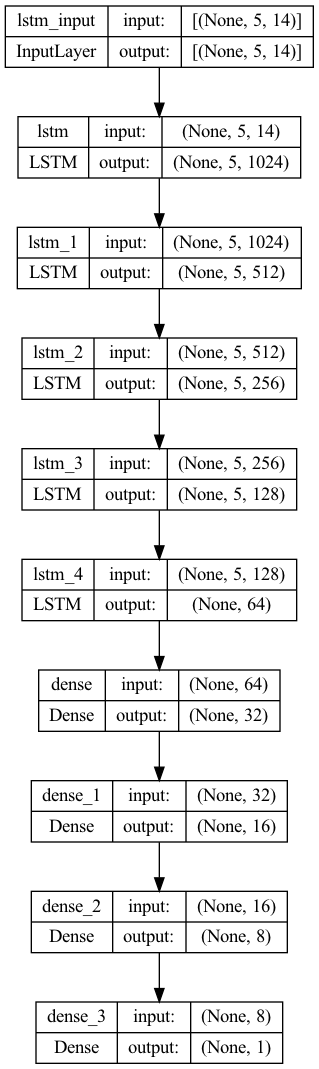

In [42]:
# Use the plot_model function to draw the structure diagram of the generator model and save it as a picture file
# parameter generator: the model instance to draw
# Parameter to_file: the saved image file name, here is set to 'generator_keras_model.png'
# Parameter show_shapes: Whether to display the input and output shape information of the layer in the graph, set it to True here
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)


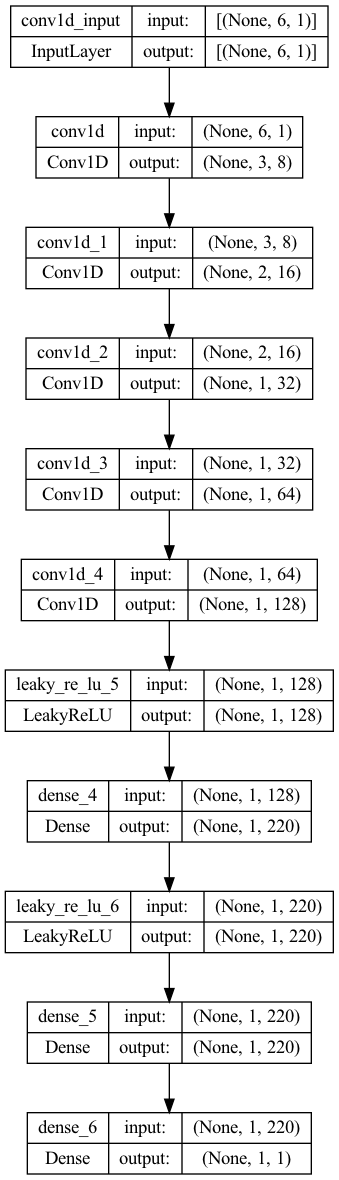

In [43]:
# Use the plot_model function to draw the structure diagram of the discriminator model and save it as a picture file
# parameter discriminator: model instance to draw
# Parameter to_file: the saved image file name, here is set to 'discriminator_keras_model.png'
# Parameter show_shapes: Whether to display the input and output shape information of the layer in the graph, set it to True here
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)


 10%|████                                      | 49/500 [00:29<02:46,  2.71it/s]

 10%|████▏                                     | 50/500 [00:30<03:00,  2.50it/s]

epoch 50 discriminator_loss 1.3860643 generator_loss 0.6945028


 20%|████████▎                                 | 99/500 [00:48<02:29,  2.68it/s]

 20%|████████▏                                | 100/500 [00:48<02:40,  2.49it/s]

epoch 100 discriminator_loss 1.3861849 generator_loss 0.6932325


 30%|████████████▏                            | 149/500 [01:07<02:09,  2.70it/s]

 30%|████████████▎                            | 150/500 [01:07<02:17,  2.54it/s]

epoch 150 discriminator_loss 1.3858428 generator_loss 0.69387907


 40%|████████████████▎                        | 199/500 [01:25<01:50,  2.73it/s]

 40%|████████████████▍                        | 200/500 [01:26<01:56,  2.57it/s]

epoch 200 discriminator_loss 1.3869452 generator_loss 0.7555974


 50%|████████████████████▍                    | 249/500 [01:44<01:34,  2.66it/s]

 50%|████████████████████▌                    | 250/500 [01:45<01:40,  2.49it/s]

epoch 250 discriminator_loss 1.3863423 generator_loss 0.68644613


 60%|████████████████████████▌                | 299/500 [02:03<01:13,  2.73it/s]

 60%|████████████████████████▌                | 300/500 [02:03<01:18,  2.55it/s]

epoch 300 discriminator_loss 1.3865117 generator_loss 0.6927233


 70%|████████████████████████████▌            | 349/500 [02:21<00:55,  2.73it/s]

 70%|████████████████████████████▋            | 350/500 [02:22<00:58,  2.56it/s]

epoch 350 discriminator_loss 1.3864586 generator_loss 0.6931583


 80%|████████████████████████████████▋        | 399/500 [02:40<00:38,  2.60it/s]

 80%|████████████████████████████████▊        | 400/500 [02:40<00:41,  2.43it/s]

epoch 400 discriminator_loss 1.386605 generator_loss 0.69361365


 90%|████████████████████████████████████▊    | 449/500 [02:59<00:18,  2.72it/s]

 90%|████████████████████████████████████▉    | 450/500 [02:59<00:19,  2.56it/s]

epoch 450 discriminator_loss 1.3860534 generator_loss 0.69319725


100%|████████████████████████████████████████▉| 499/500 [03:17<00:00,  2.75it/s]

100%|█████████████████████████████████████████| 500/500 [03:18<00:00,  2.52it/s]

epoch 500 discriminator_loss 1.3863387 generator_loss 0.6942218


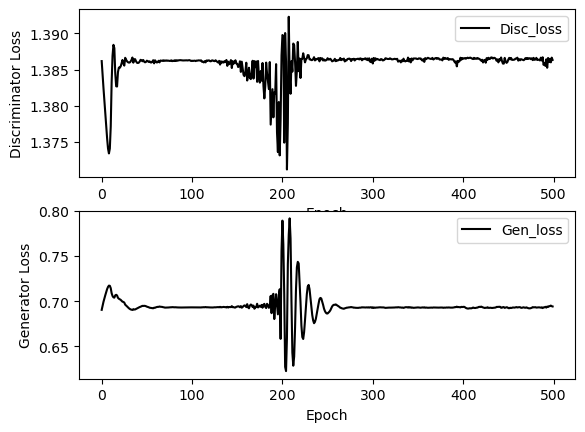

In [44]:
# Call the train function for training and return the prediction results, true price and RMSPE (relative mean square percentage error)
# Parameter X_train: input features of training data
# Parameter y_train: the real price of training data
# Parameter yc_train: additional features of the training data (may be influencing factors of other factors)
# Parameter epochs: the number of iterations of training
# Parameter generator: generator model instance
# Parameter discriminator: discriminator model instance
# Parameter g_optimizer: generator optimizer
# Parameter d_optimizer: optimizer of the discriminator
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)


In [45]:
# Load the trained generator model
# Parameter stock_name: stock name or identification, used to specify the file path where the model is saved
# parameter epochs: the total number of iterations of training

test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')


Test RMSE:  29.702684897672196


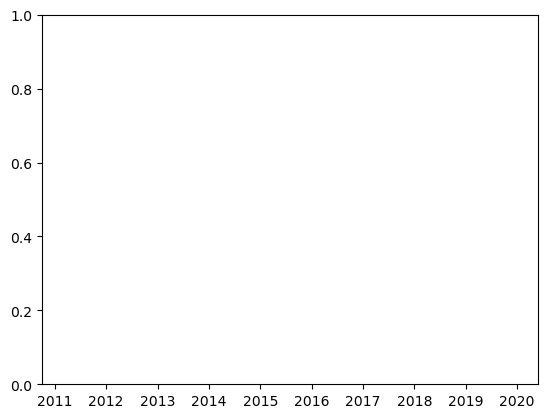

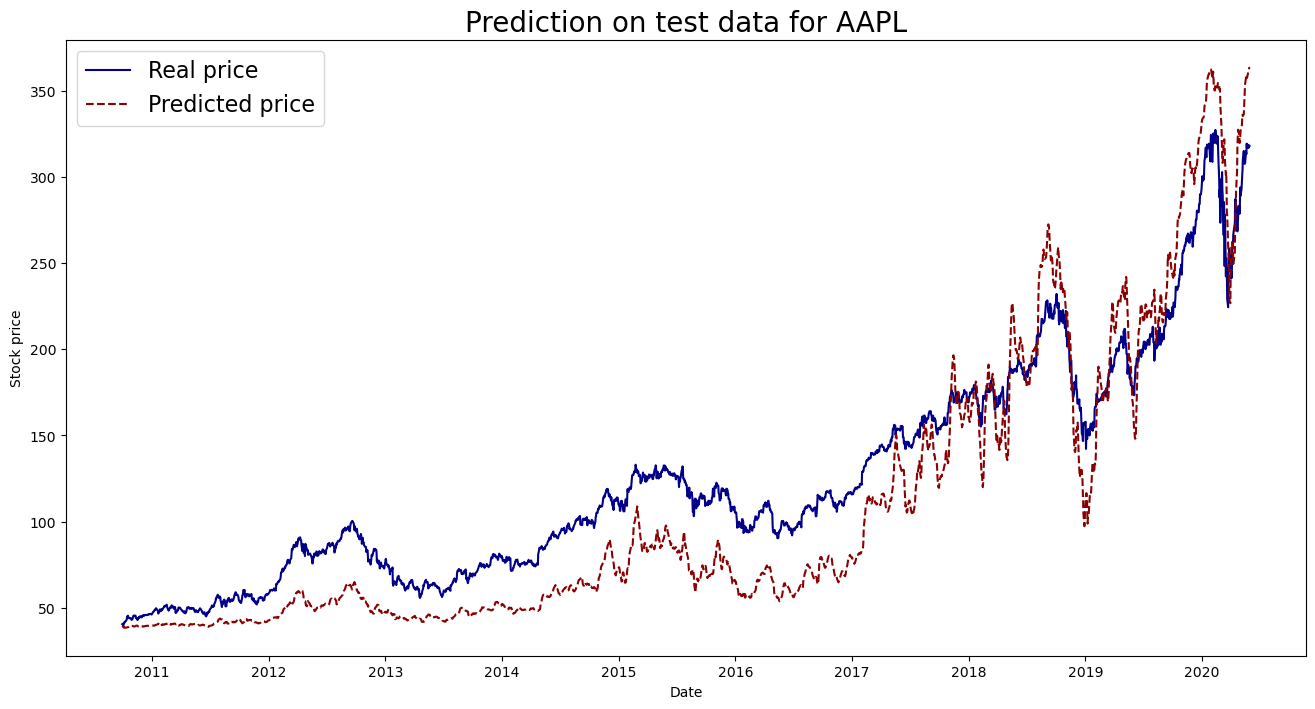

In [46]:
# Use the trained generator model to make predictions on the test data
# Parameter test_generator: The loaded and trained generator model
# Parameter X_test: The test data features
# Returns predicted_test_data: Predicted results on the test data by the generator model, including stock price predictions

predicted_test_data = eval_op(test_generator, X_test)

# Visualize the predicted results and real values
# Parameter y_test: Real test data labels (stock prices)
# Parameter predicted_test_data: Predicted results on the test data by the generator model
# Parameter index_test: Index of the test data used to display the corresponding dates

plot_test_data(y_test, predicted_test_data, index_test)
